In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model,Sequential
from keras.constraints import MaxNorm
from keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#выгружаем датасет, делаем подготовку трейн тест
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


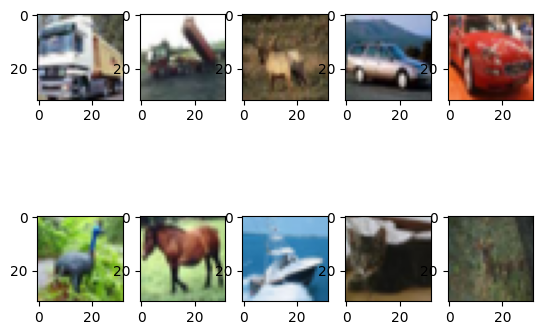

In [3]:
#смотрим что у нас загрузилось
import matplotlib.pyplot as plt
for i in range(1,11):
    plt.subplot(2, 5, i)
    plt.imshow(X_train[i])

In [4]:
#задаем архитектуру автоэнкодера
ae = Sequential()

ae.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
ae.add(BatchNormalization())     # 32x32x32
ae.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
ae.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
ae.add(BatchNormalization())     # 16x16x32
ae.add(UpSampling2D())
ae.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
ae.add(BatchNormalization())
ae.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

ae.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9

In [5]:
#будем использовать гауссовский шум разной формы для каждой эпохи
#зададим число эпох и ско шума
num_epochs = 15
noise_scale = 0.5

for i in range(num_epochs):
    print(f"Эпоха №{i + 1} из {num_epochs}")
    noise = np.random.normal(0, noise_scale, X_train.shape)
    ae.fit(X_train + noise, X_train, epochs=1, batch_size=100)

Эпоха №1 из 15
500/500 [==============================] - 50s 99ms/step - loss: 0.0135 - accuracy: 0.5802
Эпоха №2 из 15
500/500 [==============================] - 49s 97ms/step - loss: 0.0106 - accuracy: 0.6189
Эпоха №3 из 15
500/500 [==============================] - 50s 100ms/step - loss: 0.0103 - accuracy: 0.6288
Эпоха №4 из 15
500/500 [==============================] - 51s 102ms/step - loss: 0.0101 - accuracy: 0.6343
Эпоха №5 из 15
500/500 [==============================] - 52s 103ms/step - loss: 0.0101 - accuracy: 0.6375
Эпоха №6 из 15
500/500 [==============================] - 52s 104ms/step - loss: 0.0100 - accuracy: 0.6390
Эпоха №7 из 15
500/500 [==============================] - 51s 102ms/step - loss: 0.0099 - accuracy: 0.6403
Эпоха №8 из 15
500/500 [==============================] - 52s 103ms/step - loss: 0.0099 - accuracy: 0.6420
Эпоха №9 из 15
500/500 [==============================] - 54s 107ms/step - loss: 0.0099 - accuracy: 0.6429
Эпоха №10 из 15
500/500 [==============

<b>Посмотрим что у нас получится без шумов</b>

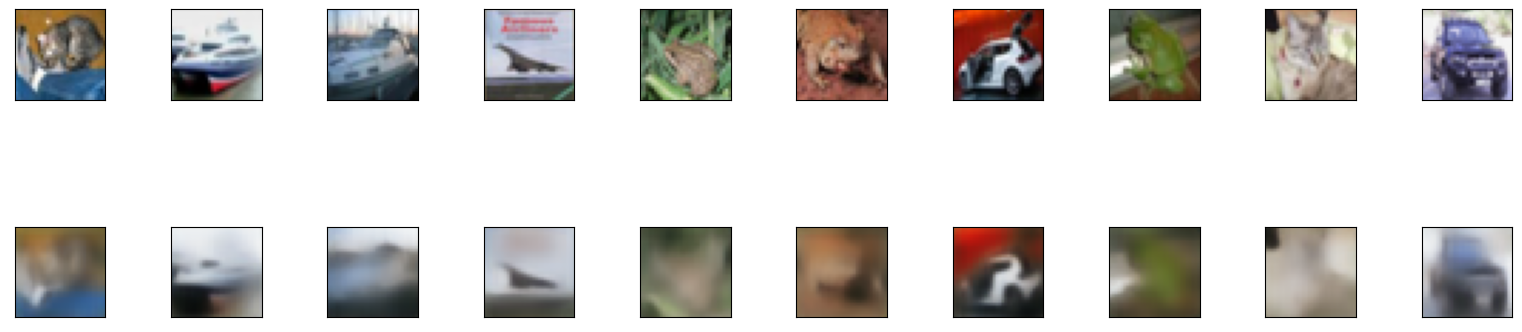

In [6]:
#проверим модель на чистых данных
#делаем предикт
pred = ae.predict(X_test)

#выводим изображения
plt.figure(figsize=(40,4))
for i in range(10):
    # из датасета
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_test[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # с выхода автоэнкодера
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(pred[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

<b>Проверим модель на зашумленных данных</b>

In [7]:
#создаем функцию, которая добавит нам шум на изображения
def add_noise(data, sigma):
    gauss = np.random.normal(loc=0.0, scale=sigma, size=data.size)
    gauss = gauss.reshape(data.shape).astype('float32')
    
    noisy_data = data + gauss #создаем зашумленный тест
    noisy_data = np.clip(noisy_data, 0, 1)  #ограничиваем диапазон по шуму
    
    return noisy_data

In [8]:
#создаем зашумленные данные
data = X_test #переприсваиваем
sigma = 0.5 #СКО шума 0.5 по заданию

X_test_noisy = add_noise(data, sigma)

In [9]:
#сделаем предикт, получим отфильтрованный тест
X_test_filtered = ae.predict(X_test_noisy)

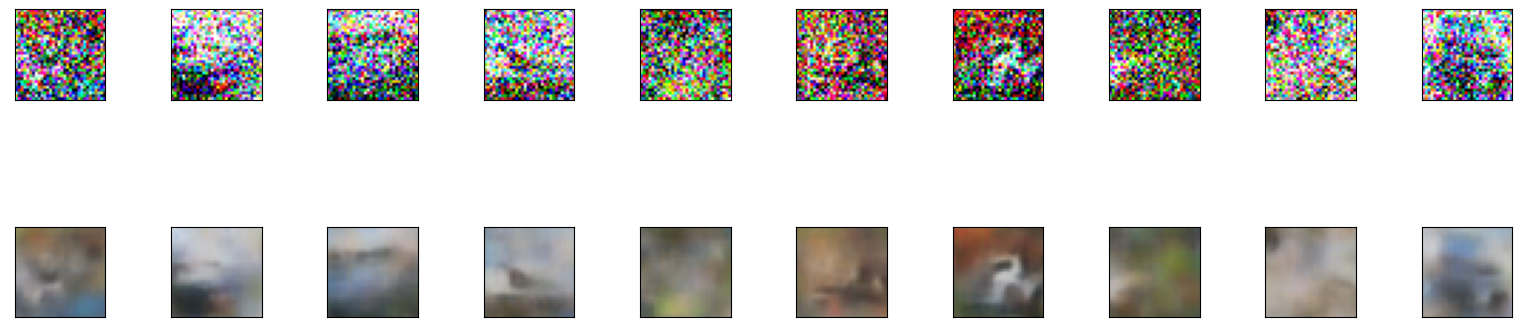

In [10]:
#выведем те же 10 изображений до фильтрации и после
plt.figure(figsize=(40,4))
for i in range(10):
    # из датасета
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_test_noisy[i].reshape(32, 32,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # с выхода автоэнкодера
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(X_test_filtered[i].reshape(32, 32,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [11]:
#автоэнкодер обучен, первые 3 пункта сделаны.
#выберем изображения разных типов из тестовой выборки
#напишем функцию, которая поможет нам в отборе изображений
#эта функция возвращает порядковый номер элемента массива, когда он встречается в первый раз
def make_idx(arr):
    seen = {}
    result = []
    
    for i, num in enumerate(arr):
        if num not in seen:
            seen[num] = i
            result.append(i)
    
    return result

In [12]:
#применим функцию, получим номера 10 исходных изображений разного типа, 
#на которых мы будем тестить нейронки
idx = make_idx(y_test.flatten())
idx

[0, 1, 3, 4, 6, 11, 12, 13, 22, 25]

<b>Теперь, в соответствии с п. 4-6 задания, выведем 10 изображений разного типа</b>

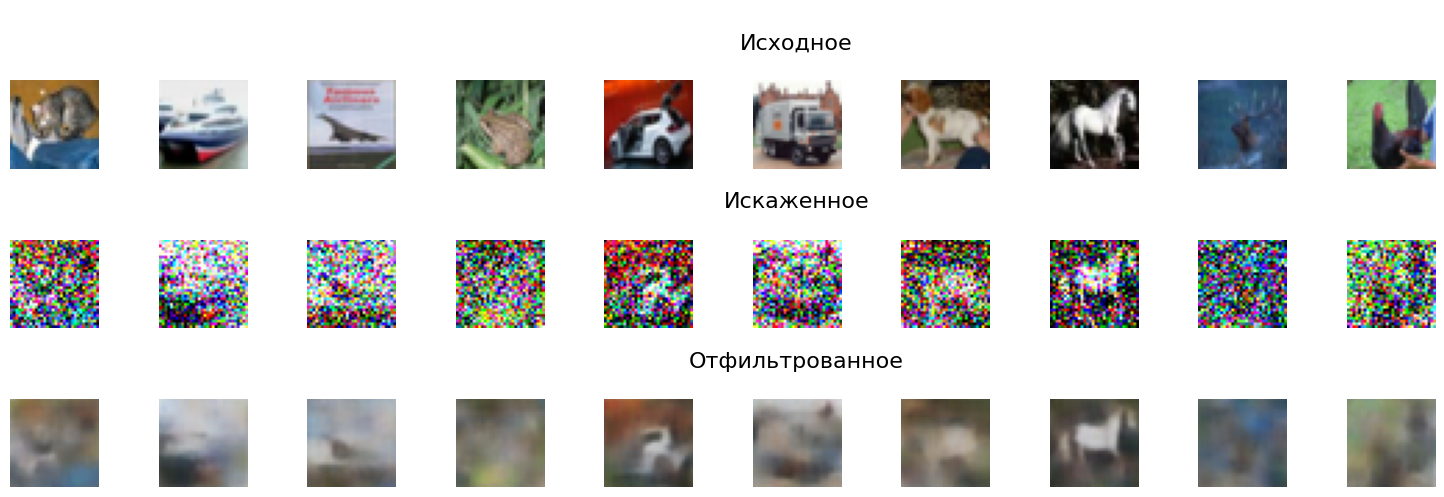

In [13]:
fontsize = 16 #размер шрифта
fig, axs = plt.subplots(3, len(idx), figsize=(15, 5))

for i, index in enumerate(idx):
    #исходное
    axs[0, i].imshow(X_test[index])
    axs[0, i].axis('off')
    if i == int(len(idx)/2):
        axs[0, i].set_title('\nИсходное\n', fontsize=fontsize)

    #искаженное
    axs[1, i].imshow(X_test_noisy[index])
    axs[1, i].axis('off')
    if i == int(len(idx)/2):
        axs[1, i].set_title('\nИскаженное\n', fontsize=fontsize)

    #отфильтрованное
    axs[2, i].imshow(X_test_filtered[index])
    axs[2, i].axis('off')
    if i == int(len(idx)/2):
        axs[2, i].set_title('\nОтфильтрованное\n', fontsize=fontsize)

plt.tight_layout()
plt.show()

<b>Вернемся к нейронной сети из задания 2. Класс по заданию был frog</b>

In [14]:
#обработаем тестовую выборку. Извлечем из датасета только изображения лягушек
#лягушка имеет №6, находим в тесте все, что не является лягушкой
cnd = y_test.flatten() == 6
y_test_frogs = y_test[cnd]
X_test_frogs = X_test[cnd]

#кодирование выходов
y_test_frogs = to_categorical(y_test_frogs, num_classes = 10)

np.shape(y_test_frogs)

(1000, 10)

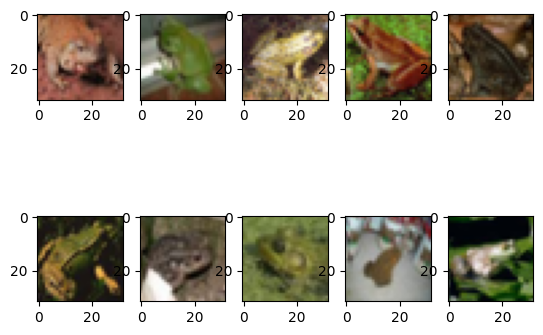

In [15]:
#среда, мои братья!
import matplotlib.pyplot as plt
for i in range(1,11):
    plt.subplot(2, 5, i)
    plt.imshow(X_test_frogs[i])

In [16]:
#Создаем лягушек с гауссовским шумом
X_test_frogs_noisy = add_noise(X_test_frogs, sigma)

In [17]:
#Создаем лягушек отфильтрованных
X_test_frogs_filtered = ae.predict(X_test_frogs_noisy)

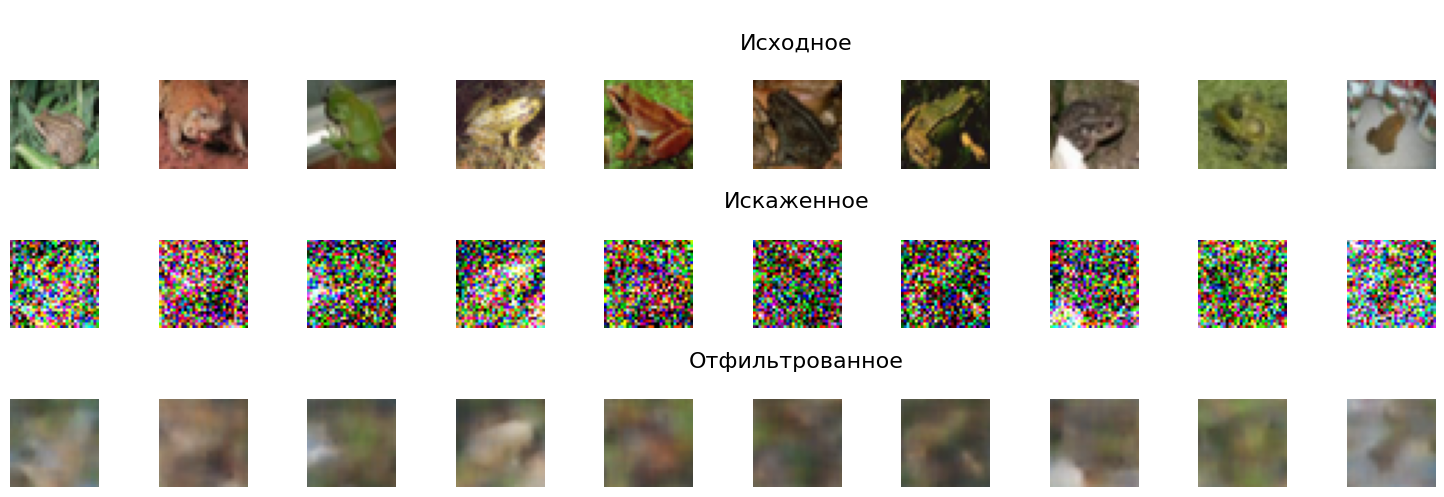

In [18]:
#Смотрим что у нас получилось
fontsize = 16 #размер шрифта
fig, axs = plt.subplots(3, len(idx), figsize=(15, 5))

for i, index in enumerate(list(range(10))):
    #исходное
    axs[0, i].imshow(X_test_frogs[index])
    axs[0, i].axis('off')
    if i == int(len(idx)/2):
        axs[0, i].set_title('\nИсходное\n', fontsize=fontsize)

    #искаженное
    axs[1, i].imshow(X_test_frogs_noisy[index])
    axs[1, i].axis('off')
    if i == int(len(idx)/2):
        axs[1, i].set_title('\nИскаженное\n', fontsize=fontsize)

    #отфильтрованное
    axs[2, i].imshow(X_test_frogs_filtered[index])
    axs[2, i].axis('off')
    if i == int(len(idx)/2):
        axs[2, i].set_title('\nОтфильтрованное\n', fontsize=fontsize)

plt.tight_layout()
plt.show()

In [19]:
#выгружаем модель из второй лабораторной работы
nnet_classifier = load_model('model100.h5')

In [20]:
#тестим классификатор на лягушках
scores = nnet_classifier.evaluate(X_test_frogs, y_test_frogs, verbose=0)
scores_noisy = nnet_classifier.evaluate(X_test_frogs_noisy, y_test_frogs, verbose=0)
scores_filtered = nnet_classifier.evaluate(X_test_frogs_filtered, y_test_frogs, verbose=0)
print("Accuracy (frogs): %.2f%%" % (scores[1]*100))
print("Accuracy (noisy frogs): %.2f%%" % (scores_noisy[1]*100))
print("Accuracy (filtered frogs): %.2f%%" % (scores_filtered[1]*100))

Accuracy (frogs): 87.90%
Accuracy (noisy frogs): 100.00%
Accuracy (filtered frogs): 0.00%


Мы получили очень интересный результат. Зашумленные изображения классифицировались с большей точностью, чем изображения без шума. На первый взгляд, дать объяснение этому феномену затруднительно. Для чистоты эксперимента, давайте проверим точность на для других классов.

In [21]:
#пропишем извлечение класса в формате функции, чтобы не повторяться
def extract_class_samples(X_test, y_test, class_num):
    condition = y_test.flatten() == class_num
    y_class = y_test[condition]
    X_class = X_test[condition]

    y_class_encoded = to_categorical(y_class, num_classes=10)

    return X_class, y_class_encoded

In [22]:
#извлечем каждый класс для тестирования нейронки
#без шума
X0, y0 = extract_class_samples(X_test, y_test, 0)
X1, y1 = extract_class_samples(X_test, y_test, 1)
X2, y2 = extract_class_samples(X_test, y_test, 2)
X3, y3 = extract_class_samples(X_test, y_test, 3)
X4, y4 = extract_class_samples(X_test, y_test, 4)
X5, y5 = extract_class_samples(X_test, y_test, 5)
X6, y6 = extract_class_samples(X_test, y_test, 6)
X7, y7 = extract_class_samples(X_test, y_test, 7)
X8, y8 = extract_class_samples(X_test, y_test, 8)
X9, y9 = extract_class_samples(X_test, y_test, 9)

In [23]:
#с шумом
X0_noisy, y0_noisy = extract_class_samples(X_test_noisy, y_test, 0)
X1_noisy, y1_noisy = extract_class_samples(X_test_noisy, y_test, 1)
X2_noisy, y2_noisy = extract_class_samples(X_test_noisy, y_test, 2)
X3_noisy, y3_noisy = extract_class_samples(X_test_noisy, y_test, 3)
X4_noisy, y4_noisy = extract_class_samples(X_test_noisy, y_test, 4)
X5_noisy, y5_noisy = extract_class_samples(X_test_noisy, y_test, 5)
X6_noisy, y6_noisy = extract_class_samples(X_test_noisy, y_test, 6)
X7_noisy, y7_noisy = extract_class_samples(X_test_noisy, y_test, 7)
X8_noisy, y8_noisy = extract_class_samples(X_test_noisy, y_test, 8)
X9_noisy, y9_noisy = extract_class_samples(X_test_noisy, y_test, 9)

In [24]:
#и после фильтрации
X0_filtered, y0_filtered = extract_class_samples(X_test_filtered, y_test, 0)
X1_filtered, y1_filtered = extract_class_samples(X_test_filtered, y_test, 1)
X2_filtered, y2_filtered = extract_class_samples(X_test_filtered, y_test, 2)
X3_filtered, y3_filtered = extract_class_samples(X_test_filtered, y_test, 3)
X4_filtered, y4_filtered = extract_class_samples(X_test_filtered, y_test, 4)
X5_filtered, y5_filtered = extract_class_samples(X_test_filtered, y_test, 5)
X6_filtered, y6_filtered = extract_class_samples(X_test_filtered, y_test, 6)
X7_filtered, y7_filtered = extract_class_samples(X_test_filtered, y_test, 7)
X8_filtered, y8_filtered = extract_class_samples(X_test_filtered, y_test, 8)
X9_filtered, y9_filtered = extract_class_samples(X_test_filtered, y_test, 9)

In [25]:
#теперь мы можем проверить сетку на других классах
#проверим на исходной тестовой выборке
scores0 = nnet_classifier.evaluate(X0, y0, verbose=0)
print("Accuracy 0: %.2f%%" % (scores0[1]*100))

scores1 = nnet_classifier.evaluate(X1, y1, verbose=0)
print("Accuracy 1: %.2f%%" % (scores1[1]*100))

scores2 = nnet_classifier.evaluate(X2, y2, verbose=0)
print("Accuracy 2: %.2f%%" % (scores2[1]*100))

scores3 = nnet_classifier.evaluate(X3, y3, verbose=0)
print("Accuracy 3: %.2f%%" % (scores3[1]*100))

scores4 = nnet_classifier.evaluate(X4, y4, verbose=0)
print("Accuracy 4: %.2f%%" % (scores4[1]*100))

scores5 = nnet_classifier.evaluate(X5, y5, verbose=0)
print("Accuracy 5: %.2f%%" % (scores5[1]*100))

scores6 = nnet_classifier.evaluate(X6, y6, verbose=0)
print("Accuracy 6: %.2f%%" % (scores6[1]*100))

scores7 = nnet_classifier.evaluate(X7, y7, verbose=0)
print("Accuracy 7: %.2f%%" % (scores7[1]*100))

scores8 = nnet_classifier.evaluate(X8, y8, verbose=0)
print("Accuracy 8: %.2f%%" % (scores8[1]*100))

scores9 = nnet_classifier.evaluate(X9, y9, verbose=0)
print("Accuracy 9: %.2f%%" % (scores9[1]*100))

Accuracy 0: 85.10%
Accuracy 1: 92.30%
Accuracy 2: 80.60%
Accuracy 3: 66.10%
Accuracy 4: 81.40%
Accuracy 5: 68.10%
Accuracy 6: 87.90%
Accuracy 7: 74.90%
Accuracy 8: 92.00%
Accuracy 9: 85.10%


In [26]:
#для исходного теста похоже на правду. проверим зашумленные данные
scores0_noisy = nnet_classifier.evaluate(X0_noisy, y0_noisy, verbose=0)
print("Accuracy 0 (noisy): %.2f%%" % (scores0_noisy[1]*100))

scores1_noisy = nnet_classifier.evaluate(X1_noisy, y1_noisy, verbose=0)
print("Accuracy 1 (noisy): %.2f%%" % (scores1_noisy[1]*100))

scores2_noisy = nnet_classifier.evaluate(X2_noisy, y2_noisy, verbose=0)
print("Accuracy 2 (noisy): %.2f%%" % (scores2_noisy[1]*100))

scores3_noisy = nnet_classifier.evaluate(X3_noisy, y3_noisy, verbose=0)
print("Accuracy 3 (noisy): %.2f%%" % (scores3_noisy[1]*100))

scores4_noisy = nnet_classifier.evaluate(X4_noisy, y4_noisy, verbose=0)
print("Accuracy 4 (noisy): %.2f%%" % (scores4_noisy[1]*100))

scores5_noisy = nnet_classifier.evaluate(X5_noisy, y5_noisy, verbose=0)
print("Accuracy 5 (noisy): %.2f%%" % (scores5_noisy[1]*100))

scores6_noisy = nnet_classifier.evaluate(X6_noisy, y6_noisy, verbose=0)
print("Accuracy 6 (noisy): %.2f%%" % (scores6_noisy[1]*100))

scores7_noisy = nnet_classifier.evaluate(X7_noisy, y7_noisy, verbose=0)
print("Accuracy 7 (noisy): %.2f%%" % (scores7_noisy[1]*100))

scores8_noisy = nnet_classifier.evaluate(X8_noisy, y8_noisy, verbose=0)
print("Accuracy 8 (noisy): %.2f%%" % (scores8_noisy[1]*100))

scores9_noisy = nnet_classifier.evaluate(X9_noisy, y9_noisy, verbose=0)
print("Accuracy 9 (noisy): %.2f%%" % (scores9_noisy[1]*100))

Accuracy 0 (noisy): 0.10%
Accuracy 1 (noisy): 0.00%
Accuracy 2 (noisy): 0.00%
Accuracy 3 (noisy): 0.00%
Accuracy 4 (noisy): 0.00%
Accuracy 5 (noisy): 0.00%
Accuracy 6 (noisy): 99.70%
Accuracy 7 (noisy): 0.00%
Accuracy 8 (noisy): 0.00%
Accuracy 9 (noisy): 0.10%


Хорошо справляется с классификацией лягушек. Продолжим анализ адекватности

In [27]:
#классифицируем зашумленный датасет полностью, посмотрим распределение по ответам нейронки
pred_X_test = nnet_classifier.predict(X_test_noisy)

#вычисляем номера предиктов для сравнения
max_col_indices = np.argmax(pred_X_test, axis=1)
max_values = np.max(pred_X_test, axis=1)

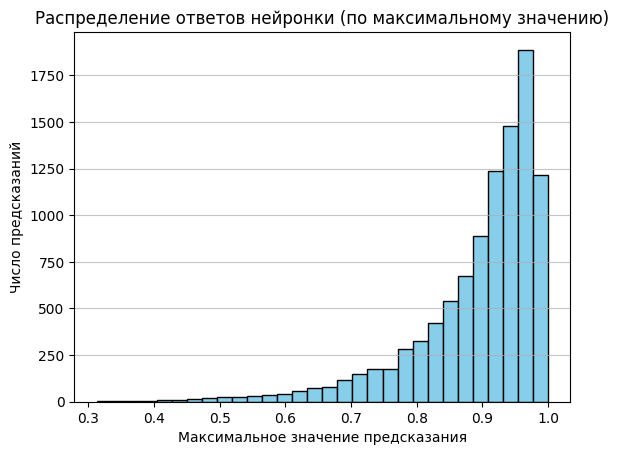

In [28]:
#гистограмма по максимумам
plt.hist(max_values, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Максимальное значение предсказания')
plt.ylabel('Число предсказаний')
plt.title('Распределение ответов нейронки (по максимальному значению)')
plt.grid(axis='y', alpha=0.75)
plt.show()

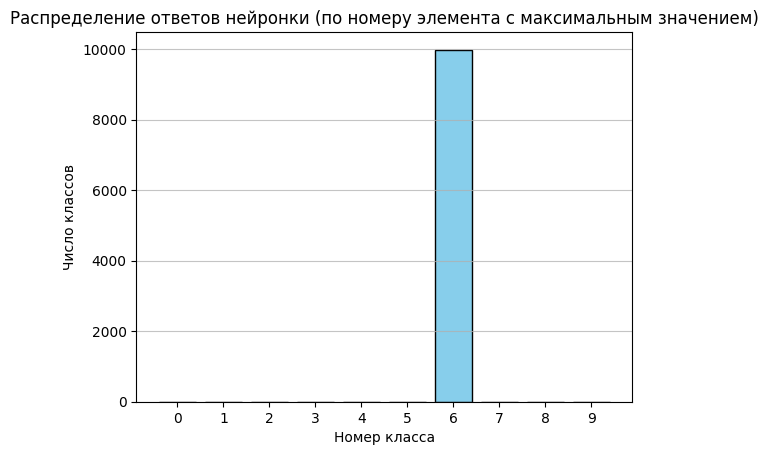

In [29]:
#гистограмма классов
plt.hist(max_col_indices, bins=np.arange(pred_X_test.shape[1] + 1) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Номер класса')
plt.ylabel('Число классов')
plt.title('Распределение ответов нейронки (по номеру элемента с максимальным значением)')
plt.xticks(range(pred_X_test.shape[1]))
plt.grid(axis='y', alpha=0.75)
plt.show()

<b>Получается такой результат.</b> Нейросеть классифицирует зашумленные изображения в основном как лягушку. Это понятно из того, что мы имеем 1000 фотографий лягушек в датасете, при этом как лягушка классифицировано около 10000 фотографий. При этом подавляющее большинство ответов нейронки - 0.9 и больше, т.е. она реально видит гауссовский шум как лягушку. Справедливости ради отметим, что сетку не обучали классифицировать гауссовский шум как гауссовский шум.

In [30]:
#посмотрим заодно данные после фильтрации
scores0_filtered = nnet_classifier.evaluate(X0_filtered, y0_filtered, verbose=0)
print("Accuracy 0 (filtered): %.2f%%" % (scores0_filtered[1]*100))

scores1_filtered = nnet_classifier.evaluate(X1_filtered, y1_filtered, verbose=0)
print("Accuracy 1 (filtered): %.2f%%" % (scores1_filtered[1]*100))

scores2_filtered = nnet_classifier.evaluate(X2_filtered, y2_filtered, verbose=0)
print("Accuracy 2 (filtered): %.2f%%" % (scores2_filtered[1]*100))

scores3_filtered = nnet_classifier.evaluate(X3_filtered, y3_filtered, verbose=0)
print("Accuracy 3 (filtered): %.2f%%" % (scores3_filtered[1]*100))

scores4_filtered = nnet_classifier.evaluate(X4_filtered, y4_filtered, verbose=0)
print("Accuracy 4 (filtered): %.2f%%" % (scores4_filtered[1]*100))

scores5_filtered = nnet_classifier.evaluate(X5_filtered, y5_filtered, verbose=0)
print("Accuracy 5 (filtered): %.2f%%" % (scores5_filtered[1]*100))

scores6_filtered = nnet_classifier.evaluate(X6_filtered, y6_filtered, verbose=0)
print("Accuracy 6 (filtered): %.2f%%" % (scores6_filtered[1]*100))

scores7_filtered = nnet_classifier.evaluate(X7_filtered, y7_filtered, verbose=0)
print("Accuracy 7 (filtered): %.2f%%" % (scores7_filtered[1]*100))

scores8_filtered = nnet_classifier.evaluate(X8_filtered, y8_filtered, verbose=0)
print("Accuracy 8 (filtered): %.2f%%" % (scores8_filtered[1]*100))

scores9_filtered = nnet_classifier.evaluate(X9_filtered, y9_filtered, verbose=0)
print("Accuracy 9 (filtered): %.2f%%" % (scores9_filtered[1]*100))

Accuracy 0 (filtered): 36.80%
Accuracy 1 (filtered): 0.00%
Accuracy 2 (filtered): 92.00%
Accuracy 3 (filtered): 1.30%
Accuracy 4 (filtered): 0.00%
Accuracy 5 (filtered): 0.00%
Accuracy 6 (filtered): 0.00%
Accuracy 7 (filtered): 0.00%
Accuracy 8 (filtered): 33.60%
Accuracy 9 (filtered): 0.00%


In [31]:
#Продолжим выполнение лабораторной работы. получаем предикты из X_test_filtered и X_test_noisy, т.е. с полных датасетов
pred_noisy = nnet_classifier.predict(X_test_noisy)
pred_filtered = nnet_classifier.predict(X_test_filtered)

In [32]:
#переделаем код из второй лабы в функцию, чтобы не повторяться
def find_failed_indices(predictions, true_labels, target_class=6):
    #вычисляем номера предиктов для сравнения
    pred = np.argmax(predictions, axis=1)
    
    #здесь переконвертировал значения лейблов в номера классов
    labels = np.argmax(true_labels, axis=1)
    
    #лейблы, где есть целевой класс
    target_true = (labels == target_class)
    
    #ошибки классификации
    fail_true = (pred != labels)
    
    #целевой класс и ошибки
    target_and_fails_true = (target_true & fail_true)
    
    #индексы ошибочно классифицированных целевых классов
    fail_idx = np.where(target_and_fails_true == True)
    
    return fail_idx

In [33]:
#настало время перекодировать y_test
y_test = to_categorical(y_test, num_classes = 10)

In [34]:
#проверим правильность функции на данных из второй лабораторки
pred = nnet_classifier.predict(X_test)
pred_falied_idx = find_failed_indices(pred, y_test)
list(pred_falied_idx)

[array([   7,   49,   59,  112,  162,  186,  221,  309,  459,  570,  672,
         685,  893, 1012, 1034, 1035, 1147, 1178, 1309, 1394, 1403, 1572,
        1580, 1838, 1935, 1939, 1989, 2251, 2267, 2299, 2309, 2447, 2455,
        2499, 2508, 2530, 2599, 2849, 3014, 3075, 3160, 3214, 3325, 3349,
        3373, 3400, 3446, 3615, 3662, 3693, 3785, 3933, 4016, 4044, 4066,
        4301, 4304, 4329, 4423, 4477, 4482, 4669, 4744, 4894, 4943, 5072,
        5106, 5203, 5388, 5446, 5487, 5581, 5600, 5607, 5850, 5883, 5927,
        5961, 6443, 6523, 6558, 6598, 6656, 6803, 6856, 7152, 7181, 7183,
        7213, 7445, 7471, 7711, 7907, 7983, 8020, 8119, 8306, 8314, 8425,
        8524, 8545, 8573, 8634, 8691, 8721, 8728, 8804, 8923, 8932, 8940,
        9092, 9216, 9294, 9359, 9501, 9641, 9705, 9727, 9786, 9801, 9877],
       dtype=int64)]

In [35]:
#похоже на правду. Получим номера для pred_noisy
pred_noisy_falied_idx = find_failed_indices(pred_noisy, y_test)
list(pred_noisy_falied_idx)

[array([ 501, 8978, 9224], dtype=int64)]

In [36]:
#и pred_filtered
pred_filtered_falied_idx = find_failed_indices(pred_filtered, y_test)
list(pred_filtered_falied_idx)

[array([   4,    5,    7,   19,   29,   30,   41,   43,   49,   59,   62,
          64,   71,   93,   95,   96,  102,  107,  112,  140,  142,  146,
         152,  162,  163,  186,  221,  226,  229,  272,  282,  292,  296,
         299,  300,  301,  304,  309,  311,  329,  333,  334,  341,  347,
         379,  380,  392,  395,  413,  429,  459,  461,  476,  481,  501,
         511,  512,  529,  534,  535,  536,  542,  547,  556,  562,  570,
         574,  575,  590,  593,  605,  610,  616,  617,  632,  635,  653,
         663,  670,  672,  681,  685,  687,  710,  728,  746,  747,  756,
         761,  762,  770,  772,  777,  783,  788,  820,  827,  861,  891,
         893,  901,  902,  907,  920,  927,  952,  963,  964,  965,  966,
         976,  994, 1009, 1012, 1017, 1028, 1029, 1032, 1034, 1035, 1058,
        1062, 1069, 1071, 1079, 1080, 1081, 1087, 1089, 1092, 1094, 1125,
        1135, 1140, 1143, 1147, 1154, 1178, 1184, 1192, 1195, 1204, 1211,
        1225, 1226, 1245, 1273, 1289, 

In [37]:
#при таком уровне шума фильтрация гауссовского шума выглядит нецелесообразной задачей. Рассмотрим ско 0.3
X_test_frogs_noisy03 = add_noise(X_test_frogs, 0.3)
X_test_frogs_filtered03 = ae.predict(X_test_frogs_noisy03)

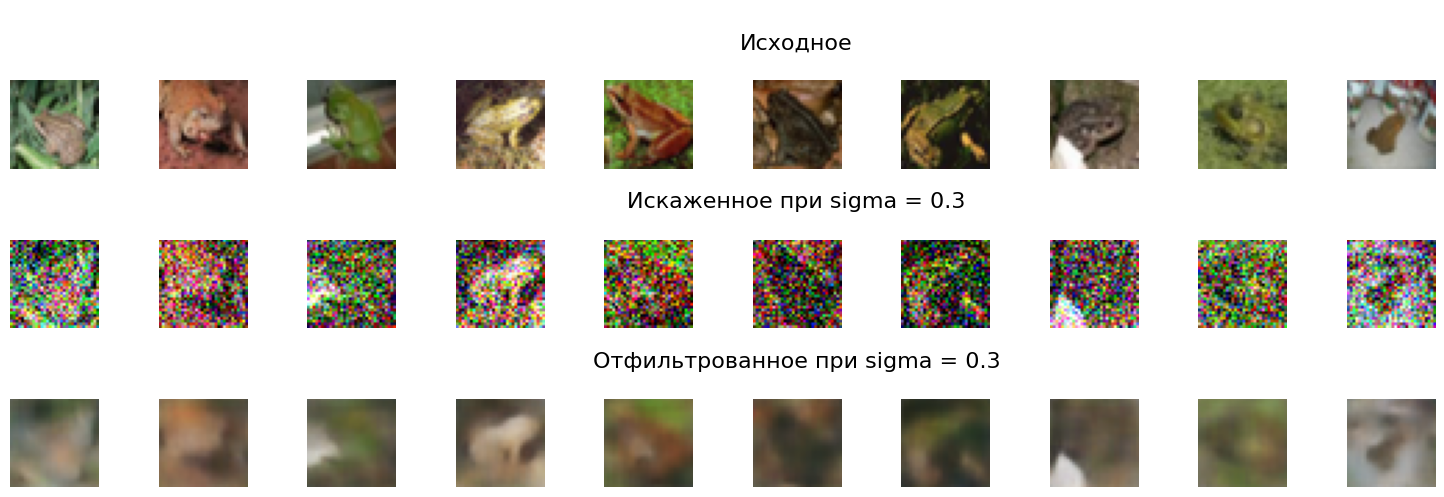

In [38]:
#Смотрим что у нас получилось
fontsize = 16 #размер шрифта
fig, axs = plt.subplots(3, len(idx), figsize=(15, 5))

for i, index in enumerate(list(range(10))):
    #исходное
    axs[0, i].imshow(X_test_frogs[index])
    axs[0, i].axis('off')
    if i == int(len(idx)/2):
        axs[0, i].set_title('\nИсходное\n', fontsize=fontsize)

    #искаженное
    axs[1, i].imshow(X_test_frogs_noisy03[index])
    axs[1, i].axis('off')
    if i == int(len(idx)/2):
        axs[1, i].set_title('\nИскаженное при sigma = 0.3\n', fontsize=fontsize)

    #отфильтрованное
    axs[2, i].imshow(X_test_frogs_filtered03[index])
    axs[2, i].axis('off')
    if i == int(len(idx)/2):
        axs[2, i].set_title('\nОтфильтрованное при sigma = 0.3\n', fontsize=fontsize)

plt.tight_layout()
plt.show()

In [39]:
#и ско 0.1
X_test_frogs_noisy01 = add_noise(X_test_frogs, 0.1)
X_test_frogs_filtered01 = ae.predict(X_test_frogs_noisy01)

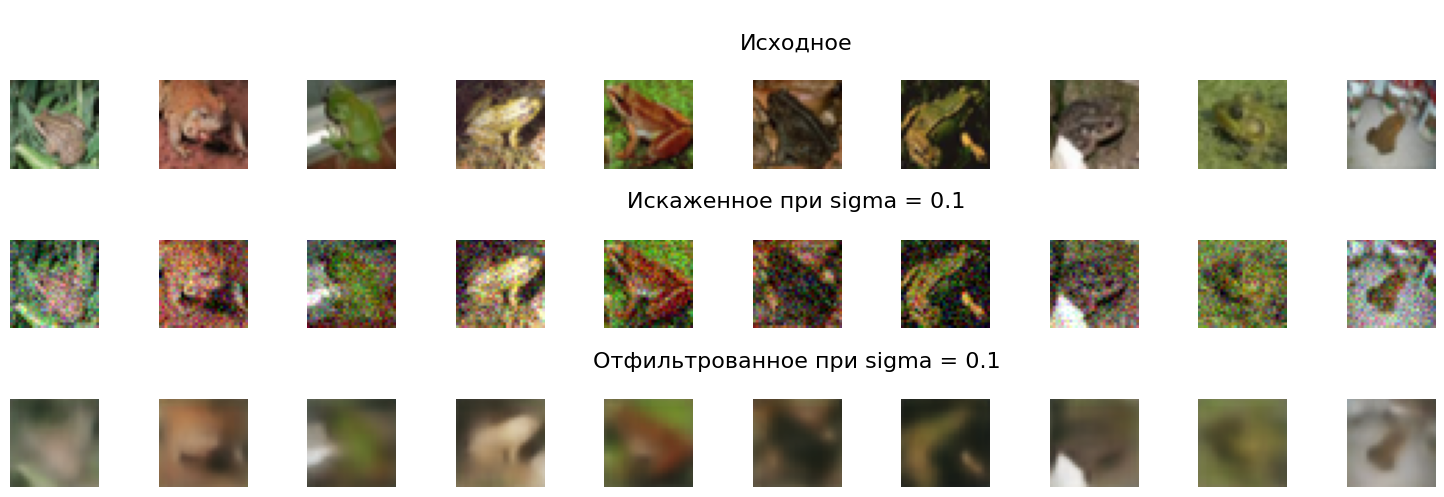

In [40]:
#Смотрим что у нас получилось
fontsize = 16 #размер шрифта
fig, axs = plt.subplots(3, len(idx), figsize=(15, 5))

for i, index in enumerate(list(range(10))):
    #исходное
    axs[0, i].imshow(X_test_frogs[index])
    axs[0, i].axis('off')
    if i == int(len(idx)/2):
        axs[0, i].set_title('\nИсходное\n', fontsize=fontsize)

    #искаженное
    axs[1, i].imshow(X_test_frogs_noisy01[index])
    axs[1, i].axis('off')
    if i == int(len(idx)/2):
        axs[1, i].set_title('\nИскаженное при sigma = 0.1\n', fontsize=fontsize)

    #отфильтрованное
    axs[2, i].imshow(X_test_frogs_filtered01[index])
    axs[2, i].axis('off')
    if i == int(len(idx)/2):
        axs[2, i].set_title('\nОтфильтрованное при sigma = 0.1\n', fontsize=fontsize)

plt.tight_layout()
plt.show()

In [41]:
#посмотрим что у нас получится в целом
#наносим шумы
X_test_noisy03 = add_noise(data, 0.3)
X_test_noisy01 = add_noise(data, 0.1)

X_test_filtered_03 = ae.predict(X_test_noisy03)
X_test_filtered_01 = ae.predict(X_test_noisy01)

acc03 = nnet_classifier.evaluate(X_test_filtered_03, y_test, verbose=0)
print("Accuracy (sigma = 0.3): %.2f%%" % (acc03[1]*100))

acc01 = nnet_classifier.evaluate(X_test_filtered_01, y_test, verbose=0)
print("Accuracy (sigma = 0.1): %.2f%%" % (acc01[1]*100))

Accuracy (sigma = 0.3): 18.61%
Accuracy (sigma = 0.1): 20.40%
